In [1]:
##########################
## Tweakable parameters ##
##########################

# Sobol analysis
problem_name = 'ungrouped'
calc_second_order = False
n_samples = 1000
save=True
results_folder='../../results/calibrations/COVID19_SEIQRD/national/others/'
results_name='sobol_overall'

# Model setup
n_age_groups = 10
start_calibration = '2020-03-15'
end_calibration = '2020-10-01'

In [2]:
############################
## Load Required Packages ##
############################

%load_ext autoreload
%autoreload 2

import os, sys
import datetime
import pandas as pd
import numpy as np
import multiprocessing as mp
import matplotlib.pyplot as plt
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.plotting.bar import plot as barplot
from covid19model.data import sciensano
from covid19model.models.utils import initialize_COVID19_SEIQRD_hybrid_vacc
from covid19model.optimization.objective_fcns import ll_poisson, ll_negative_binomial, log_posterior_probability

##################################################
## Load data not needed to initialize the model ##
##################################################

# Sciensano hospital and vaccination data
df_hosp, df_mort, df_cases, df_vacc = sciensano.get_sciensano_COVID19_data(update=False)
df_hosp = df_hosp.groupby(by=['date']).sum()
# Serological data
df_sero_herzog, df_sero_sciensano = sciensano.get_serological_data()

#############################
## Handle script arguments ##
#############################

# Number of age groups used in the model
age_stratification_size=int(n_age_groups)
# Date at which script is started
run_date = str(datetime.date.today())
# Keep track of runtime
initial_time = datetime.datetime.now()
# Start and end of calibration
start_calibration = pd.to_datetime(start_calibration)
if end_calibration:
    end_calibration = pd.to_datetime(end_calibration)

In [3]:
##########################
## Initialize the model ##
##########################

model, BASE_samples_dict, initN = initialize_COVID19_SEIQRD_hybrid_vacc(age_stratification_size=age_stratification_size, start_date=start_calibration.strftime("%Y-%m-%d"), update_data=False)

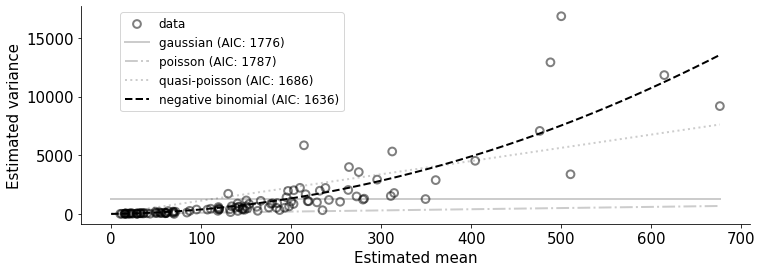

In [4]:
#############################################################
## Compute the overdispersion parameters for our H_in data ##
#############################################################

from covid19model.optimization.utils import variance_analysis
results, ax = variance_analysis(df_hosp['H_in'], resample_frequency='W')
plt.show()
plt.close()

#############################################
## Initialize the log probability function ##
#############################################

data=[df_hosp['H_in'][start_calibration:end_calibration], df_sero_herzog['abs','mean'], df_sero_sciensano['abs','mean'][:16]]
states = ["H_in", "R", "R"]
weights = np.array([1, 1e-3, 1e-3]) # Scores of individual contributions: 1) 17055, 2+3) 255 860, 3) 175571
log_likelihood_fnc = [ll_negative_binomial, ll_poisson, ll_poisson]
log_likelihood_fnc_args = [results.loc['negative binomial', 'theta'], [], []]

In [5]:
#########################################
## Setup the Sobol sensitivity problem ##
#########################################

problem_grouped = {
    'num_vars': 11,
    'groups': ['Group_1','Group_1','Group_1','Group_1',
              'Group_2',
              'Group_3',
              'Group_4', 'Group_4', 'Group_4', 'Group_4', 'Group_4'],
    'names': ['beta','omega','a','da',
              'amplitude',
              'zeta',
              'mentality','eff_schools', 'eff_work', 'eff_rest', 'eff_home'],
    'labels': ['$R_{0}$: $\\beta$, $\\omega$, a, $d_{a}$',
               '$A_{s}$',
               '$\\zeta$',
               '$N_{c}$: M, $\Omega_{schools}$ ,\n  $\Omega_{work}$, $\Omega_{rest}$, $\Omega_{work}$'],
    'bounds': [
        [0.50*model.parameters['beta'], 1.50*model.parameters['beta']],[0.50*model.parameters['omega'], 1.50*model.parameters['omega']],[0.01, 0.57],[0.50*model.parameters['da'], 1.50*model.parameters['da']],
        [0.50*model.parameters['amplitude'], 1.50*model.parameters['amplitude']],
        [0.50*model.parameters['zeta'], 1.50*model.parameters['zeta']],
        [0,1],[0,1],[0,1],[0,1],[0,1]
               ]
}

problem_ungrouped = {
    'num_vars': 11,
    'names': ['beta','omega','a','da',
              'amplitude',
              'zeta',
              'mentality','eff_schools', 'eff_work', 'eff_rest', 'eff_home'],
    'labels': ['$\\beta$', '$\\omega$', 'a', '$d_{a}$',
               '$A_{s}$',
               '$\\zeta$',
               'M', '$\Omega_{schools}$', '$\Omega_{work}$', '$\Omega_{rest}$', '$\Omega_{work}$'],
    'bounds': [
        [0.50*model.parameters['beta'], 1.50*model.parameters['beta']],[0.50*model.parameters['omega'], 1.50*model.parameters['omega']],[0.01, 0.57],[0.50*model.parameters['da'], 1.50*model.parameters['da']],
        [0.50*model.parameters['amplitude'], 1.50*model.parameters['amplitude']],
        [0.50*model.parameters['zeta'], 1.50*model.parameters['zeta']],
        [0,1],[0,1],[0,1],[0,1],[0,1]
               ]
}

problems = {'grouped': problem_grouped, 'ungrouped': problem_ungrouped}

problem = problems[problem_name]

In [6]:
#####################################################
## Setup the sensitivity analysis helper functions ##
#####################################################

def adjust_h(overall_h):
    virgin_h = np.array(model.parameters['h'])
    return list(virgin_h*(overall_h/0.115)) # Verified 11.5% is the implemented Belgian population average (04/08/2022)

def adjust_a(overall_a):
    virgin_a = np.array(model.parameters['a'])
    return list(virgin_a*(overall_a/0.57)) # Verified 57.0% is the implemented Belgian population average (04/08/2022)

def draw_fcn(param_dict,samples_dict):
    param_dict['sigma'] = 5.2*np.ones(len(param_dict['sigma'])) - param_dict['omega']
    return param_dict 

flatten = lambda *n: (e for a in n for e in (flatten(*a) if isinstance(a, (tuple, list)) else (a,)))

# Pre-compile objective function
pars=problem['names']
objective_function = log_posterior_probability([],[],model,pars,data,states,log_likelihood_fnc,log_likelihood_fnc_args,-weights)

def evaluate_model(thetas):
    thetas = list(thetas)
    # Rescale 'a' and 'h' from population averages to vectors
    thetas[2] = adjust_a(thetas[2]) 
    #thetas[4] = adjust_h(thetas[4])
    # Flatten the resulting list containing a mix of lists and floats
    thetas = list(flatten(thetas))
    return objective_function(thetas, simulation_kwargs={'draw_fcn': draw_fcn})

In [ ]:
##########################
## Perform the analysis ##
##########################

# Perform sampling
param_values = saltelli.sample(problem, n_samples, calc_second_order=calc_second_order)
print(param_values.shape[0])

# Evaluate model (automatic multiprocessing and suppression of warnings)

import warnings
warnings.filterwarnings('ignore')

thetas = param_values
mp_pool = mp.Pool(int(mp.cpu_count()/2))
output = np.array(mp_pool.map(evaluate_model, thetas))
mp_pool.close()

# Compute sobol weights
Si = sobol.analyze(problem, output, calc_second_order=calc_second_order)


#################################
## Bundle and save the results ##
#################################

if calc_second_order:
    total_Si, first_Si, second_Si = Si.to_df()
    if save:
        pd.concat([pd.concat([total_Si, first_Si], axis=1), second_Si]).to_csv(results_folder+results_name+'.csv')
else:
    total_Si, first_Si = Si.to_df()
    if save:
        pd.concat([total_Si, first_Si], axis=1).to_csv(results_folder+results_name+'.csv')

13000


/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.10/site-packages/SALib/sample/saltelli.py:94: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (1000) is equal to `2^n`.
        
  warnings.warn(msg)


In [ ]:
#############################
## Visualize sobol weights ##
#############################

df_plot = pd.concat([total_Si, first_Si], axis=1)

fig,ax=plt.subplots(figsize=(12,4))
# Bar plot
ax = df_plot.plot(kind = "bar", y = ["S1", "ST"], yerr=df_plot[['S1_conf', 'ST_conf']].values.T, capsize=8,
                  color=['white','black'], alpha=0.4, edgecolor='black', ax=ax)
# Legend
ax.legend(bbox_to_anchor=(1, 1))
# Labels
if problem_name == 'grouped':
    labels = problem_grouped['labels']
else:
    labels = problem_ungrouped['labels']
x_pos = np.arange(len(labels))
plt.xticks(x_pos, labels, rotation=0)
# Axes limit
ax.set_ylim([-0.1,1])
# Grid
ax.grid(False)
# Visualize
plt.tight_layout()
plt.show()
# Save
fig.savefig(results_folder+results_name+'.pdf')
# Close
plt.close()